# Seminário Data Augmentation

IA898 - Processamento Digital de Imagem - 2S2018

Aluna: Júlia Borges


Esse notebook tem o objetivo de complementar a apresentação do seminário cujo tema é Data Augmentation. Nele serão apresentados maneiras de aplicar esse conceito em uma base de imagens. 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from PIL import Image
import random
from scipy import ndarray
import skimage as sk
from skimage import transform
from skimage import util
from skimage import io

A seguir estão implementadas algumas funções que podem ser usadas para aplicação da técnica de Data Augmentation. São elas: 
    - Rotação de um ângulo aleatório entre 90 graus para direita e 90 graus para a esquerda.
    - Adição de ruído gaussiano
    - Adição de ruído sal & pimenta
    - Reflexão horizontal
    - Reflexão vertical
    - Redução da resolução espacial
    - Adição de um valor aleatório entre 10 e 50 em um dos canais da imagem RGB
    - Cortes de regiões das imagens
    - Translação horizontal
    - Translação vertical

In [3]:
def random_rotation(image_array):
    # pick a random degree of rotation between 90 on the left and 90 on the right
    random_degree = random.uniform(-90, 90)
    return sk.transform.rotate(image_array, random_degree)

def random_noise(image_array: ndarray):
    image = np.copy(image_array)
    if image.min() < 0:
        low_clip = -1.
    else:
        low_clip = 0.

    image = sk.img_as_float(image)
    mean = 0.
    var = 0.01
    # add random noise to the image
    noise = np.random.normal(mean, var ** 0.5, image.shape)
    out = image + noise
    out = np.clip(out, low_clip, 1.0)
    return out

def salt_and_pepper_noise(image_array: ndarray):
    if image_array.ndim == 2:
        row,col = image_array.shape
    else:
        row,col,ch = image_array.shape
        
    # add a salt and pepper noise
    s_vs_p = 0.5
    amount = 0.004
    out = np.copy(image_array)
    # Salt mode
    num_salt = np.ceil(amount * image_array.size * s_vs_p)
    coords_y = [np.random.randint(0, row, int(num_salt))]
    coords_x = [np.random.randint(0, col, int(num_salt))]        
    out[coords_y, coords_x] = 255

    # Pepper mode
    num_pepper = np.ceil(amount* image_array.size * (1. - s_vs_p))
    coords_y = [np.random.randint(0, row, int(num_pepper))]
    coords_x = [np.random.randint(0, col, int(num_pepper))]
    out[coords_y, coords_x] = 0
    
    return out


def horizontal_flip(image_array: ndarray):
    # horizontal flip doesn't need skimage, it's easy as flipping the image array of pixels !
    return image_array[:, ::-1]

def vertical_flip(image_array: ndarray):
    # vertical flip doesn't need skimage, it's easy as flipping the image array of pixels !
    return image_array[::-1, :]

def rescale(image_array: ndarray):
    img = np.copy(image_array)
    # rescale the image by a factor
    random.seed()
    random_factor = random.choice([2, 4, 8])
    return img[::random_factor,::random_factor]

def intensity_color(image_array: ndarray):
    img = np.copy(image_array)
    
    if image_array.ndim == 3:
        random_ch = random.randint(0,3)
        random_value = random.randint(10, 50)
        img[:,:,random_ch] = img[:,:,random_ch] + random_value
        
    else:
        random_value = random.randint(10, 50)
        img[:,:] = img[:,:] + random_value
    return img

def crop2(image_array: ndarray, new_x, new_y): 
    img = np.copy(image_array)
    return img[new_x:,new_y:]

def crop2_left_top(image_array: ndarray, new_x, new_y): 
    img = np.copy(image_array)
    return img[new_x:,:new_y]

def crop2_down(image_array: ndarray, new_x, new_y): 
    img = np.copy(image_array)
    return img[:new_x,new_y:]

def crop2_left_down(image_array: ndarray, new_x, new_y): 
    img = np.copy(image_array)
    return img[:new_x, :new_y]

def crop2_center(image_array: ndarray,cropx,cropy):
    if image_array.ndim == 2:
        y,x = image_array.shape
    else:
        y,x, z = image_array.shape
        
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)  
    
    img = np.copy(image_array)
    
    return img[starty:starty+cropy,startx:startx+cropx]

def crop(image_array: ndarray, new_x, new_y): 
    img = np.copy(image_array)
    img[:new_x,:] = 0
    img[:,:new_y] = 0
    return img

def crop_left_top(image_array: ndarray, new_x, new_y): 
    img = np.copy(image_array)
    img[:new_x,:] = 0
    img[:,new_y:] = 0
    return img

def crop_down(image_array: ndarray, new_x, new_y): 
    img = np.copy(image_array)
    img[new_x:,:] = 0
    img[:,:new_y] = 0
    return img

def crop_left_down(image_array: ndarray, new_x, new_y): 
    img = np.copy(image_array)
    img[new_x:,:] = 0
    img[:,new_y:] = 0
    return img

def crop_center(image_array: ndarray,cropx,cropy):
    if image_array.ndim == 2:
        y,x = image_array.shape
    else:
        y,x, z = image_array.shape
        
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)  
    
    img = np.copy(image_array)
    img[starty:starty+cropy,startx:startx+cropx]
    img[:starty,:] = 0
    img[:,:startx] = 0
    img[starty+cropy:,:] = 0
    img[:,startx+cropx:] = 0
    return img

def x_trans_slice(img_slice, x_vox_trans):
    # Make a 0-filled array of same shape as `img_slice`
    trans_slice = np.zeros(img_slice.shape)
    # Use slicing to select voxels out of the image and move them
    # up or down on the first (x) axis
    if x_vox_trans < 0:
        if img_slice.ndim == 2:
            trans_slice[:x_vox_trans, :] = img_slice[-x_vox_trans:, :]
            
        else:
            trans_slice[:x_vox_trans, :, 0] = img_slice[-x_vox_trans:, :, 0]
            trans_slice[:x_vox_trans, :, 1] = img_slice[-x_vox_trans:, :, 1]
            trans_slice[:x_vox_trans, :, 2] = img_slice[-x_vox_trans:, :, 2]
    elif x_vox_trans == 0:
        trans_slice[:, :] = img_slice
    else:
        if img_slice.ndim == 2:
            trans_slice[x_vox_trans:, :] = img_slice[:-x_vox_trans, :]
            
        else:
            trans_slice[x_vox_trans:, :, 0] = img_slice[:-x_vox_trans, :, 0]
            trans_slice[x_vox_trans:, :, 1] = img_slice[:-x_vox_trans, :, 1]
            trans_slice[x_vox_trans:, :, 2] = img_slice[:-x_vox_trans, :, 2]
    return trans_slice.astype('uint8')

def y_trans_slice(img_slice, y_vox_trans):
    # Make a 0-filled array of same shape as `img_slice`
    trans_slice = np.zeros(img_slice.shape)
    # Use slicing to select voxels out of the image and move them
    # up or down on the first (x) axis
    if y_vox_trans < 0:
        if img_slice.ndim == 2:
            trans_slice[:, :y_vox_trans] = img_slice[:,-y_vox_trans:]
        else:
            trans_slice[:, :y_vox_trans, 0] = img_slice[:,-y_vox_trans:, 0]
            trans_slice[:, :y_vox_trans, 1] = img_slice[:,-y_vox_trans:, 1]
            trans_slice[:, :y_vox_trans, 2] = img_slice[:,-y_vox_trans:, 2]
    elif y_vox_trans == 0:
        trans_slice[:, :] = img_slice
    else:
        if img_slice.ndim == 2:
            trans_slice[:,y_vox_trans:] = img_slice[:, :-y_vox_trans]
        else:
            trans_slice[:,y_vox_trans:, 0] = img_slice[:, :-y_vox_trans, 0]
            trans_slice[:,y_vox_trans:, 1] = img_slice[:, :-y_vox_trans, 1]
            trans_slice[:,y_vox_trans:, 2] = img_slice[:, :-y_vox_trans, 2]
    return trans_slice.astype('uint8')

# dictionary of the transformations functions we defined earlier
available_transformations = {
    'rotate': random_rotation,
    'noise': random_noise,
    'salt_and_pepper_noise': salt_and_pepper_noise,
    'horizontal_flip': horizontal_flip,
    'vertical_flip': vertical_flip,
    'rescale': rescale,
    'crop': crop,
    'crop_left_top': crop_left_top,
    'crop_down': crop_down,
    'crop_left_down': crop_left_down,
    'crop_center': crop_center,
    'crop2': crop2,
    'crop2_left_top': crop2_left_top,
    'crop2_down': crop2_down,
    'crop2_left_down': crop2_left_down,
    'crop2_center': crop2_center,
    'intensity_color': intensity_color,
    'x_trans_slice': x_trans_slice,
    'y_trans_slice': y_trans_slice
    
}

f = Image.open('176.jpg')
f = np.array(f)

A seguir serão testadas as funções acima definidas.

## Transformações geométricas

A célula abaixo contém a imagem original rotacionada em 3 ângulos diferentes.

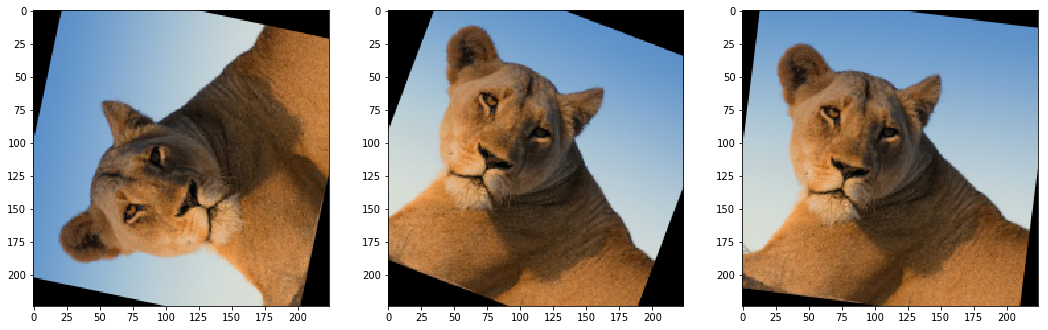

In [4]:
key = 'rotate'
transformed_image1 = available_transformations[key](f)

transformed_image2 = available_transformations[key](f)

transformed_image3 = available_transformations[key](f)

fig=plt.figure(figsize=(18, 10))

fig.add_subplot(1, 3, 1)
plt.imshow(transformed_image1)

fig.add_subplot(1, 3, 2)
plt.imshow(transformed_image2)

fig.add_subplot(1, 3, 3)
plt.imshow(transformed_image3)

plt.show()

A célula abaixo contém a imagem original, a imagem refletida horizontalmente e, em seguida, verticalmente.

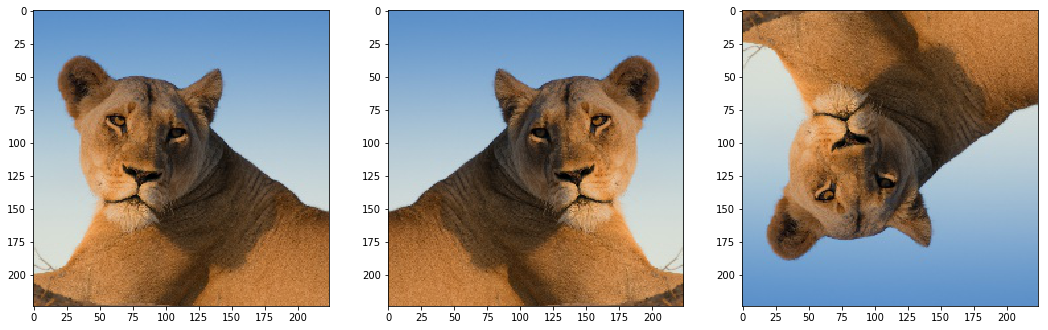

In [4]:
key = 'horizontal_flip'
transformed_imageHF = available_transformations[key](f)

key = 'vertical_flip'
transformed_imageVF = available_transformations[key](f)

fig=plt.figure(figsize=(18, 10))

fig.add_subplot(1, 3, 1)
plt.imshow(f, cmap='gray')


fig.add_subplot(1, 3, 2)
plt.imshow(transformed_imageHF, cmap='gray')

fig.add_subplot(1, 3, 3)
plt.imshow(transformed_imageVF, cmap='gray')

plt.show()

A célula abaixo testa a função de redução da resolução espacial da imagem. A função escolhe de maneira aleatória se irá diminuir pela metade, um quarto ou um oitavo a quantidade de pixels da imagem. O resultado desse teste mostra primeiro a imagem original, e depois duas chamadas da função.

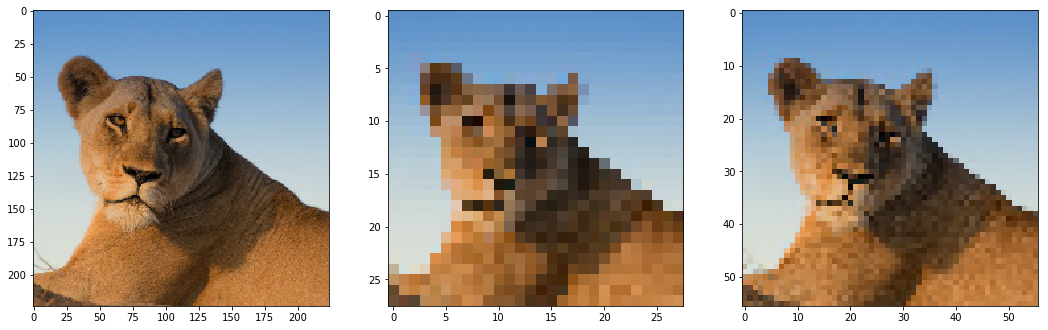

In [22]:
key = 'rescale'
transformed_image4 = available_transformations[key](f)

transformed_image5 = available_transformations[key](f)

fig=plt.figure(figsize=(18, 10))

fig.add_subplot(1, 3, 1)
plt.imshow(f)

fig.add_subplot(1, 3, 2)
plt.imshow(transformed_image4)

fig.add_subplot(1, 3, 3)
plt.imshow(transformed_image5)

plt.show()

A célula abaixo mostra o teste com as funções de cortes de regiões da imagem. As imagens representam cortes nas regiões inferiror esquerda, superior esquerda, inferior direita, superior direita e centro da imagem.

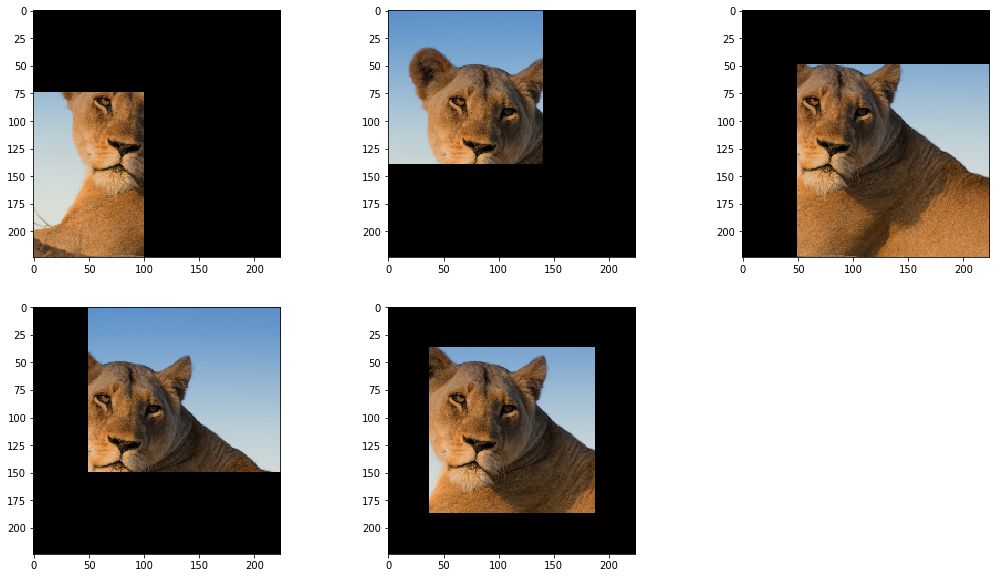

In [6]:
key = 'crop_left_top'
transformed_image6 = available_transformations[key](f, 75, 100)

key = 'crop_left_down'
transformed_image7 = available_transformations[key](f, 140, 140)

key = 'crop'
transformed_image8 = available_transformations[key](f, 50, 50)

key = 'crop_down'
transformed_image9 = available_transformations[key](f, 150, 50)

key = 'crop_center'
transformed_image10 = available_transformations[key](f, 150, 150)

fig=plt.figure(figsize=(18, 10))

fig.add_subplot(2, 3, 1)
plt.imshow(transformed_image6)

fig.add_subplot(2, 3, 2)
plt.imshow(transformed_image7)

fig.add_subplot(2, 3, 3)
plt.imshow(transformed_image8)

fig.add_subplot(2, 3, 4)
plt.imshow(transformed_image9)

fig.add_subplot(2, 3, 5)
plt.imshow(transformed_image10)

plt.show()

Nessa segunda versão da função de cortes, a imagem retornada não contém o mesmo tamanho da imagem original, por isso não possui as regiões em preto. Entretanto, as imagens serão de tamanhos variados, dependendo da região do corte que os parâmetros da função definem.

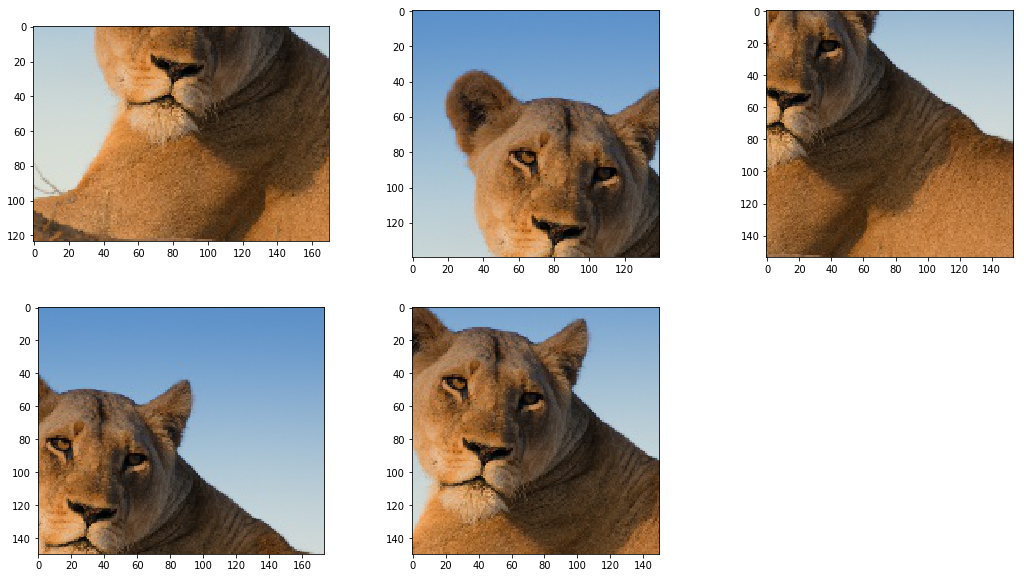

In [7]:
key = 'crop2_left_top'
transformed_image11 = available_transformations[key](f, 100, 170)

key = 'crop2_left_down'
transformed_image12 = available_transformations[key](f, 140, 140)

key = 'crop2'
transformed_image13 = available_transformations[key](f, 70, 70)

key = 'crop2_down'
transformed_image14 = available_transformations[key](f, 150, 50)

key = 'crop2_center'
transformed_image15 = available_transformations[key](f, 150, 150)

fig=plt.figure(figsize=(18, 10))

fig.add_subplot(2, 3, 1)
plt.imshow(transformed_image11)

fig.add_subplot(2, 3, 2)
plt.imshow(transformed_image12)

fig.add_subplot(2, 3, 3)
plt.imshow(transformed_image13)

fig.add_subplot(2, 3, 4)
plt.imshow(transformed_image14)

fig.add_subplot(2, 3, 5)
plt.imshow(transformed_image15)

plt.show()

A célula a seguir testa a função de translação vertical, horizontal e a combinação das duas, ou seja, aplicando uma translação e seu resultado à outra. Os parâmetros dizem respeito ao deslocamento que os pixels da imagem original devem ser submetidos.

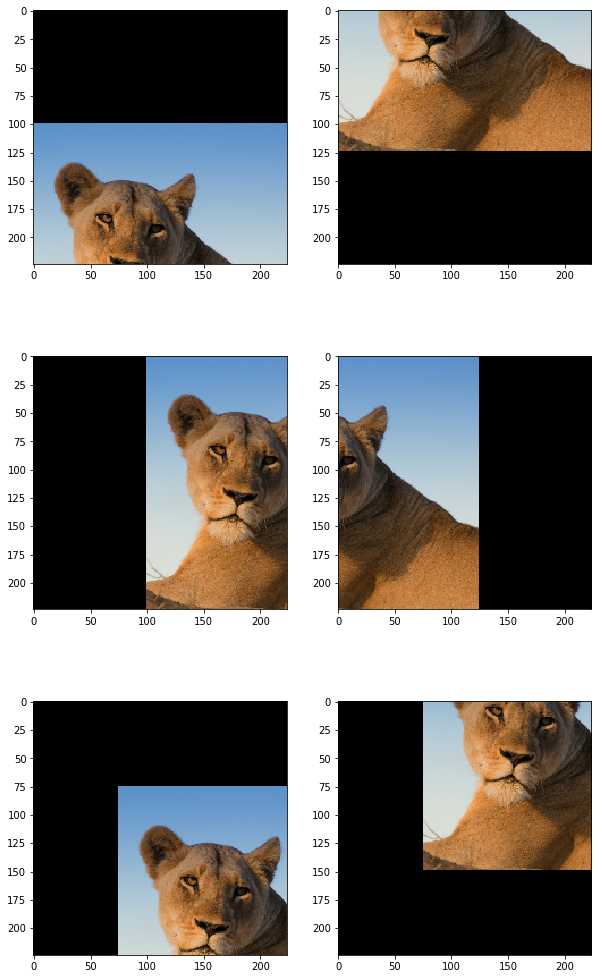

In [24]:
fig=plt.figure(figsize=(10, 18))

fig.add_subplot(3, 2, 1)
plt.imshow(x_trans_slice(f, 100))

fig.add_subplot(3, 2, 2)
plt.imshow(x_trans_slice(f, -100))

fig.add_subplot(3, 2, 3)
plt.imshow(y_trans_slice(f, 100))

fig.add_subplot(3, 2, 4)
plt.imshow(y_trans_slice(f, -100))

fig.add_subplot(3, 2, 5)
plt.imshow(x_trans_slice(y_trans_slice(f, 75), 75))

fig.add_subplot(3, 2, 6)
plt.imshow(x_trans_slice(y_trans_slice(f, 75), -75))

plt.show()

## Transformações de cor

A célula abaixo testa as duas funções de inserção de ruído. A primeira imagem é resultado da função de inserção de ruído gaussiano e a segunda, o ruído é do tipo sal & pimenta.

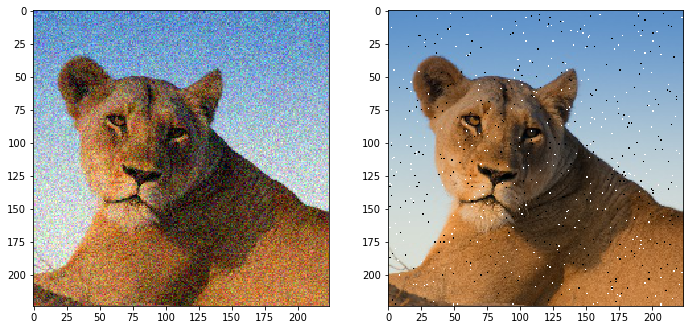

In [8]:
key = 'noise'
transformed_image11 = available_transformations[key](f)

key = 'salt_and_pepper_noise'
transformed_image12 = available_transformations[key](f)

fig=plt.figure(figsize=(18, 10))

fig.add_subplot(1, 3, 1)
plt.imshow(transformed_image11)

fig.add_subplot(1, 3, 2)
plt.imshow(transformed_image12)

plt.show()

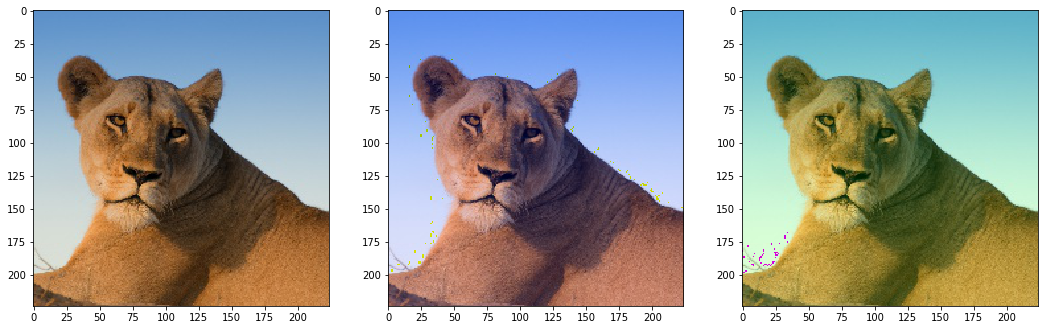

In [9]:
key = 'intensity_color'
transformed_image11 = available_transformations[key](f)

key = 'intensity_color'
transformed_image12 = available_transformations[key](f)

fig=plt.figure(figsize=(18, 10))

fig.add_subplot(1, 3, 1)
plt.imshow(f)

fig.add_subplot(1, 3, 2)
plt.imshow(transformed_image11)

fig.add_subplot(1, 3, 3)
plt.imshow(transformed_image12)

plt.show()

## Combinação de duas ou mais funções

Assim como já apresentado na função de translação, é possível combinar as transformações, de modo a gerar uma quantidade ainda maior de imagens tecnicamente diferentes, derivadas de um mesmo conjunto de dados.

O teste a seguir consiste em aplicar uma translação horizontal, seu resultado na translação vertical e por fim, aplicado à reflexão horizontal.

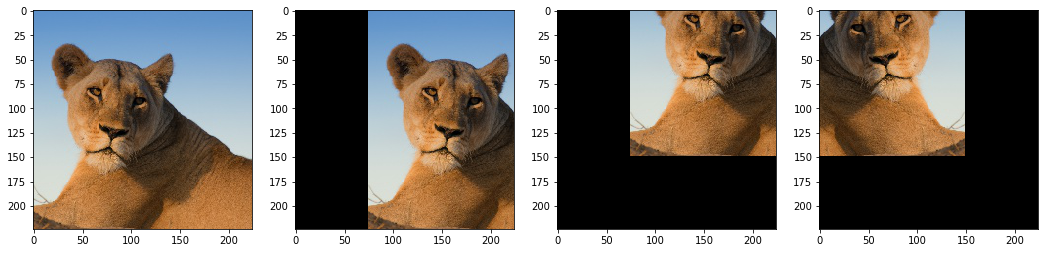

In [28]:
translated_x_y = x_trans_slice(y_trans_slice(f, 75), -75)

key = 'horizontal_flip'
transformed_imageVF = available_transformations[key](translated_x_y)


fig=plt.figure(figsize=(18, 12))

fig.add_subplot(1, 4, 1)
plt.imshow(f)

fig.add_subplot(1, 4, 2)
plt.imshow(y_trans_slice(f, 75))

fig.add_subplot(1, 4, 3)
plt.imshow(translated_x_y)

fig.add_subplot(1, 4, 4)
plt.imshow(transformed_imageVF)

plt.show()

A seguir, foi criado um cógido que gera automaticamente um número pré determinado de imagens artificiais. Ele escolhe de maneira aleatória uma das funções disponíveis de Data Augmentation. Portanto, foram selecionadas apenas as funções não parametrizadas das apresentadas acima. É preciso ter uma base de imagens inicial e após o programa ler essas imagens, ele escolhe aleatoriamente uma para realizar uma transformação. Por fim, ele salva a imagem, nomeando-a como "augmented_image + o nome da imagem original" e o critério de parada é o número de imagens desejadas ser alcançado.

In [29]:
# dictionary of the transformations we defined earlier
available_transformations = {
    'rotate': random_rotation,
    'noise': random_noise,
    'horizontal_flip': horizontal_flip,
    'vertical_flip': vertical_flip,
    'salt_and_pepper_noise': salt_and_pepper_noise,
    'rescale': rescale
}
                               
folder_path = '../../lion'

num_files_desired = 20

# find all files paths from the folder
images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

num_generated_files = 0
while num_generated_files <= num_files_desired:
    # random image from the folder
    image_path = random.choice(images)
    # read image as an two dimensional array of pixels
    image_to_transform = Image.open(image_path)
    image_to_transform = np.array(image_to_transform)
    # random num of transformation to apply
    num_transformations_to_apply = random.randint(1, len(available_transformations))
    num_transformations = 0
    transformed_image = None
    while num_transformations <= num_transformations_to_apply:
        # random transformation to apply for a single image
        key = random.choice(list(available_transformations))
        transformed_image = available_transformations[key](image_to_transform)
        num_transformations += 1

    #save images
    #define a name for our new file
    new_file_path = '%s/augmented_image_%s.jpg' % (folder_path, num_generated_files)

    # write image to the disk
    sk.io.imsave(new_file_path, transformed_image)
    num_generated_files += 1

/home/julia/.local/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
